# Concise Implementation of Softmax Regression

Just as Gluon made it much easier
to implement linear regression in :numref:`sec_linear_gluon`,
we will find it similarly (or possibly more)
convenient for implementing classification models.
Again, we begin with our import ritual.

In [1]:
import d2l
from mxnet import gluon, init, npx
from mxnet.gluon import nn
npx.set_np()

Let's stick with the Fashion-MNIST dataset 
and keep the batch size at $256$ as in the last section.

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model Parameters

As mentioned in :numref:`sec_softmax`,
the output layer of softmax regression 
is a fully-connected (`Dense`) layer.
Therefore, to implement our model,
we just need to add one `Dense` layer 
with 10 outputs to our `Sequential`.
Again, here, the `Sequential` is not really necessary,
but we might as well form the habit since it will be ubiquitous
when implementing deep models.
Again, we initialize the weights at random
with zero mean and standard deviation $0.01$.

In [3]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

## The Softmax

In the previous example, we calculated our model's output
and then ran this output through the cross-entropy loss.
Mathematically, that is a perfectly reasonable thing to do.
However, from a computational perspective, 
exponentiation can be a source of numerical stability issues
(as discussed  in :numref:`sec_naive_bayes`).
Recall that the softmax function calculates
$\hat y_j = \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}$, 
where $\hat y_j$ is the $j^\mathrm{th}$ element of ``yhat`` 
and $z_j$ is the $j^\mathrm{th}$ element of the input
``y_linear`` variable, as computed by the softmax.

If some of the $z_i$ are very large (i.e., very positive),
then $e^{z_i}$ might be larger than the largest number
we can have for certain types of ``float`` (i.e., overflow).
This would make the denominator (and/or numerator) ``inf`` 
and we wind up encountering either $0$, ``inf``, or ``nan`` for $\hat y_j$.
In these situations we do not get a well-defined 
return value for ``cross_entropy``.
One trick to get around this is to first subtract $\text{max}(z_i)$
from all $z_i$ before proceeding with the ``softmax`` calculation.
You can verify that this shifting of each $z_i$ by constant factor
does not change the return value of ``softmax``.

After the subtraction and normalization step,
it might be that possible that some $z_j$ have large negative values
and thus that the corresponding $e^{z_j}$ will take values close to zero.
These might be rounded to zero due to finite precision (i.e underflow),
making $\hat y_j$ zero and giving us ``-inf`` for $\text{log}(\hat y_j)$.
A few steps down the road in backpropagation,
we might find ourselves faced with a screenful 
of the dreaded not-a-number (``nan``) results.

Fortunately, we are saved by the fact that 
even though we are computing exponential functions, 
we ultimately intend to take their log 
(when calculating the cross-entropy loss).
By combining these two operators 
(``softmax`` and ``cross_entropy``) together,
we can escape the numerical stability issues
that might otherwise plague us during backpropagation.
As shown in the equation below, we avoided calculating $e^{z_j}$
and can instead $z_j$ directly due to the canceling in $\log(\exp(\cdot))$.

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{e^{z_j}}{\sum_{i=1}^{n} e^{z_i}}\right) \\
& = \log{(e^{z_j})}-\text{log}{\left( \sum_{i=1}^{n} e^{z_i} \right)} \\
& = z_j -\log{\left( \sum_{i=1}^{n} e^{z_i} \right)}.
\end{aligned}
$$

We will want to keep the conventional softmax function handy
in case we ever want to evaluate the probabilities output by our model.
But instead of passing softmax probabilities into our new loss function,
we will just pass the logits and compute the softmax and its log
all at once inside the softmax_cross_entropy loss function,
which does smart things like the log-sum-exp trick ([see on Wikipedia](https://en.wikipedia.org/wiki/LogSumExp)).

In [4]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimization Algorithm

Here, we use minibatch stochastic gradient descent
with a learning rate of $0.1$ as the optimization algorithm.
Note that this is the same as we applied in the linear regression example
and it illustrates the general applicability of the optimizers.

In [5]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Training

Next we call the training function defined in the last section to train a model.

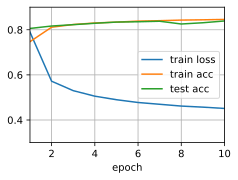

In [6]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

As before, this algorithm converges to a solution
that achieves an accuracy of 83.7%,
albeit this time with fewer lines of code than before.
Note that in many cases, Gluon takes additional precautions
beyond these most well-known tricks to ensure numerical stability,
saving us from even more pitfalls that we would encounter
if we tried to code all of our models from scratch in practice.

## Exercises

1. Try adjusting the hyper-parameters, such as batch size, epoch, and learning rate, to see what the results are.
1. Why might the test accuracy decrease again after a while? How could we fix this?

## [Discussions](https://discuss.mxnet.io/t/2337)

![](../img/qr_softmax-regression-gluon.svg)